# why is this interface so weird?

it's jupyter notebook!!

some are text blocks like this one and some are code blocks like the one below

In [1]:
for i in range(5):
    print(i) 

0
1
2
3
4


also we can run bash commands like this

In [2]:
!pwd

/Users/daspartho/Documents/GitHub/verbose-meme


# what we doing today?

[relevant xkcd comic](https://xkcd.com/1425/) from 2015 (ofcourse!)

input: some random image with either a bird or a dog in it

output: is the image of a bird or a dog

note: i highly recommend instead of "bird" and "dog" think of your own categories like idk "goku" and "naruto" and change the code below accordingly

In [3]:
cat_1 = "bird"
cat_2 = "dog"

# how?

only 2 steps:

1. download images of both categories
2. train our model

# setup

we'll be using the fastai library for neural network stuff and duckduckgo for searching images

In [4]:
!pip install -Uqq fastai duckduckgo_search # -Uqq means we use the most recent version

let's import

In [5]:
from duckduckgo_search import ddg_images
from fastcore.all import *
from fastdownload import download_url
from fastai.vision.all import *

# step 1: download images of both categories

search [duckduckgo](https://duckduckgo.com/) for images of category 1 and get the url

In [6]:
def search_images(term, max_images=100):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

In [7]:
urls = search_images(f'{cat_1} photos', max_images=1)
urls[0]

Searching for 'bird photos'


/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:60: UserWarning: ddg_images is deprecated. Use DDGS().images() generator
  warnings.warn("ddg_images is deprecated. Use DDGS().images() generator")
/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:64: UserWarning: parameter page is deprecated
  warnings.warn("parameter page is deprecated")
/Users/daspartho/anaconda3/lib/python3.10/site-packages/duckduckgo_search/compat.py:66: UserWarning: parameter max_results is deprecated
  warnings.warn("parameter max_results is deprecated")


'https://2.bp.blogspot.com/-g9STQqFQ9Ik/UScse2IifqI/AAAAAAAAA08/mh1immEtVZo/s1600/bluebird.jpg'

next we download the image from url and take a look at it

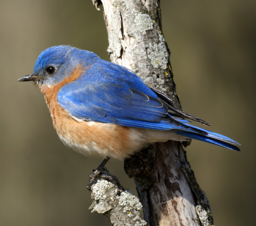

In [8]:
dest = f'{cat_1}.jpg'
download_url(urls[0], dest, show_progress=False)

im = Image.open(dest)
im.to_thumb(256,256)

let's do the same for category 2

Searching for 'dog photos'


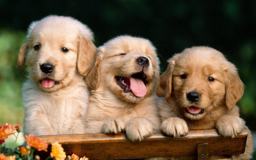

In [9]:
download_url(search_images(f'{cat_2} photos', max_images=1)[0], f'{cat_2}.jpg', show_progress=False)
Image.open(f'{cat_2}.jpg').to_thumb(256,256)

our searches seem to be giving reasonable results!

so let's grab a few examples of each category, and save each group of photos to a different folder

In [10]:
searches = cat_1, cat_2
path = Path(f'{cat_1}_or_{cat_2}')

for o in searches:
    dest = (path/o)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{o} photo'))
    resize_images(path/o, max_size=400, dest=path/o)

Searching for 'bird photo'
Searching for 'dog photo'


some photos might not download correctly which could cause our model training to fail so we'll remove them

In [11]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

1

# step 2: train our model

to train our model we'll need to structure our data a certain way using `DataBlock` so that we can get it into the model

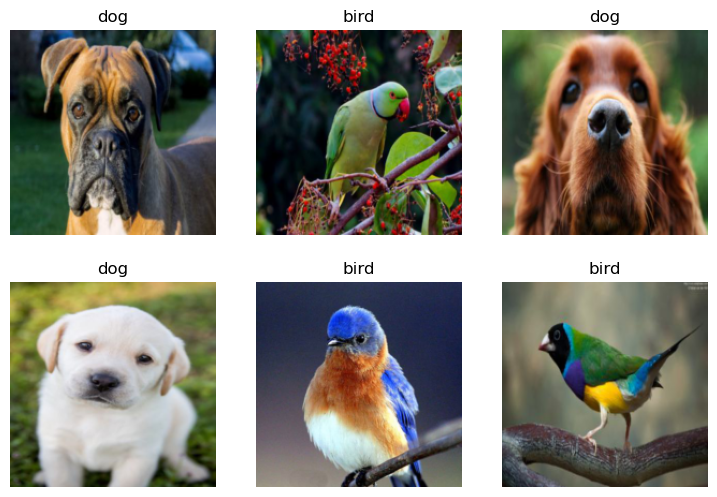

In [12]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), # input is images and output are categories
    get_items=get_image_files, # to find all the inputs to our model, we'll run the get_image_files function (which returns a list of all image files in a path)
    splitter=RandomSplitter(valid_pct=0.2, seed=42), # split data with 20% for validation set
    get_y=parent_label, # the labels is the name of the parent folder of each file (i.e. the name of the folder they're in, which will be bird or dog)
    item_tfms=[Resize(192, method='squish')] # resize each image to 192x192 pixels by "squishing" it
).dataloaders(path, bs=32) # splitting the data into batches of 32 images

dls.show_batch(max_n=6)

now we're ready to train our model

we'll finetune `resnet18` model on our dataset

In [13]:
learner = vision_learner(dls, resnet18, metrics=error_rate)
learner.fine_tune(3)

/Users/daspartho/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/daspartho/anaconda3/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


epoch,train_loss,valid_loss,error_rate,time
0,0.815632,0.064779,0.000000,00:01


epoch,train_loss,valid_loss,error_rate,time
0,0.054415,0.032934,0.029412,00:01
1,0.042028,0.012993,0.000000,00:01
2,0.027248,0.007485,0.000000,00:01


# let's use our model

let's see what our model thinks about the image we downloaded at the start

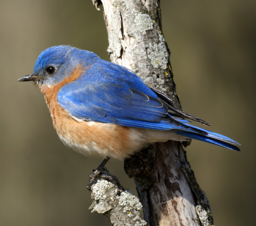

In [14]:
im.to_thumb(256,256)

In [15]:
cat,_,probs = learner.predict(PILImage.create(f'{cat_1}.jpg'))
print(f"This is a: {cat}.")
print(f"Probability: {probs[0]:.4f}")

This is a: bird.
Probability: 1.0000


Good job, `resnet18` :)

# where to learn more?

- [fastai course](https://course.fast.ai/) (i ripped-off it's first lesson)
- [3blue1brown's series on neural networks](https://www.youtube.com/playlist?list=PLZHQObOWTQDNU6R1_67000Dx_ZCJB-3pi)